#  Computing genetic diversity statistics 

Number of SNP   
Nucleotide diversity, Tajima's D, Variant density    
Alternative alleles frequencies 

In [1]:
## Importing necessary modules for the analyzes
from collections import Counter
from functools import lru_cache
import numpy as np
import pandas as pd
import h5py
import dask
import dask.array as da
# silence some dask warnings
dask.config.set(**{'array.slicing.split_large_chunks': True})
import allel
from dask.diagnostics.progress import ProgressBar
import malariagen_data

In [2]:
import itertools

In [3]:
# plotting setup
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import matplotlib_venn as venn
import seaborn as sns

sns.set_style('white')
sns.set_style('ticks')
sns.set_context('paper', font_scale=.6)
plt.rcParams['figure.dpi'] = 150
rcParams = plt.rcParams

base_font_size = 7
rcParams['font.size'] = base_font_size
rcParams['axes.titlesize'] = base_font_size
rcParams['axes.labelsize'] = base_font_size
rcParams['xtick.labelsize'] = base_font_size
rcParams['ytick.labelsize'] = base_font_size

In [4]:
# Print style 
from colorama import Fore, Back, Style
print(Fore.MAGENTA + 'To test the printing style')
print(Style.RESET_ALL) #to reset the printing style

To test the printing style



In [5]:
## Importing malariagen data set
ag3 = malariagen_data.Ag3("gs://vo_agam_release/")

In [6]:
print(Fore.MAGENTA + 'Processing...' , Style.RESET_ALL)

##Defining sample sets
sets = ['AG1000G-AO', 'AG1000G-BF-A', 'AG1000G-BF-B', 'AG1000G-BF-C', 'AG1000G-CD', 
        'AG1000G-CF','AG1000G-CI', 'AG1000G-CM-A', 'AG1000G-CM-B', 'AG1000G-CM-C', 
        'AG1000G-FR', 'AG1000G-GA-A', 'AG1000G-GH', 'AG1000G-GM-A', 'AG1000G-GM-B', 
        'AG1000G-GM-C', 'AG1000G-GN-A', 'AG1000G-GN-B', 'AG1000G-GW', 
        'AG1000G-KE', 'AG1000G-ML-A', 'AG1000G-ML-B', 'AG1000G-MW', 'AG1000G-MZ', 
        'AG1000G-TZ', 'AG1000G-UG'] 
## Selecting and defining the samples metadata
df_samples = ag3.sample_metadata(sample_sets=sets)#.set_index("sample_id")

#To access to the genotypes within the X chromosomes
chromx_gt = ag3.snp_calls(region="X", sample_sets=sets)

# SNP position in the X chromosomes 
snps_pos = allel.SortedIndex(chromx_gt['variant_position'].values)
loc_region = snps_pos.locate_range(1283016,1373662)

#To the genomics dataset within the fru region 
Fru_region = chromx_gt.sel(variants=loc_region)

# To filter the SNP dataset and warp the dataset to GT array 
filt = 'gamb_colu_arab' 
filt_val = Fru_region[f"variant_filter_pass_{filt}"].values 
gt_filtered = allel.GenotypeDaskArray(Fru_region["call_genotype"][filt_val].data)

## Warp to arrays
#with ProgressBar():
#    gt_filtered_arr = allel.GenotypeArray(gt_filtered)
#    ac = gt_filtered.count_alleles(max_allele=3).compute()
#print(Fore.MAGENTA + 'done...' , Style.RESET_ALL)

Processing... 


In [7]:
## Warp to arrays
with ProgressBar():
    gt_filtered_arr = allel.GenotypeArray(gt_filtered)
    ac = gt_filtered.count_alleles(max_allele=3).compute()
print(Fore.MAGENTA + 'done...' , Style.RESET_ALL)

[########################################] | 100% Completed |  8min  9.5s
[########################################] | 100% Completed |  7min 52.5s
done... 


In [8]:
# To get the variants positions within the target region in dsx
is_variant = ac.is_variant()
pos_df = Fru_region['variant_position'][filt_val][is_variant].compute()
pos = allel.SortedIndex(pos_df["variant_position"].values) 

# How many segregating sites
print(Fore.MAGENTA + f'The number of segregating sites is {ac.count_segregating()}.')
print(f'Total variants = {ac.count_variant()}.')
print(f'Biallelic sites = {ac.is_biallelic().sum()}.')
print(f'''Multiallelic sites = {ac.count_segregating() - ac.is_biallelic().sum()} 
      {100*(ac.count_segregating() - ac.is_biallelic().sum())/ac.count_segregating()}.''', Style.RESET_ALL)

The number of segregating sites is 34339.
Total variants = 34339.
Biallelic sites = 20071.
Multiallelic sites = 14268 
      41.55042371647398. 


In [9]:
## Compute variation 
pi = allel.sequence_diversity(snps_pos[loc_region], ac)
D = allel.tajima_d(ac, snps_pos[loc_region])
w_theta = allel.watterson_theta(snps_pos[loc_region], ac)
print(Fore.MAGENTA + f"Nucleotide diversity = {pi}; \nTajima'D = {D}; \nWatterson’s theta = {w_theta}", 
      Style.RESET_ALL)
print('......')
loc_gen = {'loc_female': (1371770, 1373662), 
           'loc_male' : (1373540, 1373662),
           'loc_BTB_exon1' : (1324890, 1325015),
           'loc_BTB_exon2' : (1324556, 1324756), 
           'loc_BTB_exon3' : (1323795, 1324463), 
           'loc_BTB_exon4' : (1323509, 1323673), 
           'loc_BTB_connector' : (1323673, 1324890),
           'loc_znfc' : (1283016, 1283775),
           'loc_znfb' : (1300109, 1300950),
           'loc_znfa' : (1308485, 1309932)
          }
# To get the variants positions within the target region in dsx
#is_variant = ac.is_variant()
pos_df1 = Fru_region['variant_position'][filt_val].compute()
pos1 = allel.SortedIndex(pos_df1["variant_position"].values) 
SNP_sites_r = []
for key in loc_gen.keys():
    loc_ = pos.locate_range(loc_gen[key][0], loc_gen[key][1])
    loc_r = pos1.locate_range(loc_gen[key][0], loc_gen[key][1])
    key_loc = pos1.locate_keys(pos1[loc_r])
    snp_sites = gt_filtered_arr[key_loc].count_alleles(max_allele=3).count_segregating()
    SNP_sites_r.append(snp_sites)
    pi_ = allel.sequence_diversity(pos[loc_], ac)
    D_ = allel.tajima_d(ac, pos[loc_])
    w_theta_ = allel.watterson_theta(pos[loc_], ac)
    print(Fore.MAGENTA + f"Segregating site in {key.split('loc_')[1]} region = {snp_sites}",
          f"\nNucleotide diversity in {key.split('loc_')[1]} region = {pi_}",
          f"\nTajima'D in {key.split('loc_')[1]} region = {D_}", 
          f"\nWatterson’s theta {key.split('loc_')[1]} region = {w_theta_}", '\n...', Style.RESET_ALL)

print(Fore.MAGENTA + f".... \nNumber of SNPs in exons : {sum(SNP_sites_r)} [{sum(SNP_sites_r)/ac.count_segregating()}]")
print(Fore.MAGENTA + 'Number of SNP in intronic region',
     f'\n {ac.count_segregating() - sum(SNP_sites_r)} [{(ac.count_segregating() - sum(SNP_sites_r))/ac.count_segregating()}]', Style.RESET_ALL)

Nucleotide diversity = 0.003615590487892711; 
Tajima'D = -2.525085616783623; 
Watterson’s theta = 0.04118373904098244 
......
Segregating site in female region = 1018 
Nucleotide diversity in female region = 0.1738686636371409 
Tajima'D in female region = -2.525085616783623 
Watterson’s theta female region = 1.9804681129166763 
... 
Segregating site in male region = 62 
Nucleotide diversity in male region = 2.8253657841035396 
Tajima'D in male region = -2.525085616783623 
Watterson’s theta male region = 32.18260683489599 
... 
Segregating site in BTB_exon1 region = 60 
Nucleotide diversity in BTB_exon1 region = 2.708615131867856 
Tajima'D in BTB_exon1 region = -2.525085616783623 
Watterson’s theta BTB_exon1 region = 30.85274704833004 
... 
Segregating site in BTB_exon2 region = 94 
Nucleotide diversity in BTB_exon2 region = 1.638712154780053 
Tajima'D in BTB_exon2 region = -2.525085616783623 
Watterson’s theta BTB_exon2 region = 18.665911964239672 
... 
Segregating site in BTB_exon3 re

In [10]:
print(Fore.MAGENTA + 'Number of SNP in intronic region',
     f'\n {ac.count_segregating() - sum(SNP_sites_r)} [{(ac.count_segregating() - sum(SNP_sites_r))/ac.count_segregating()}]')

Number of SNP in intronic region 
 31042 [0.9039867206383413]


In [11]:
## Compute the number of non-synonymous multiallelic variants 
print(Fore.MAGENTA + 'Processing...')
print('...', Style.RESET_ALL)

#Import the Non-synonymous snp tab
Non_snp = pd.read_csv('R/NonSynonymous_snp_tabs.csv')

## Look for the same SNP position in the gt data
call_pos = Fru_region['variant_position'][filt_val].compute()
call_pos1 = allel.SortedIndex(call_pos["variant_position"].values) 
len(call_pos1)

pos_ind = []
for i in allel.SortedIndex(sorted(Non_snp.position)):
    if i in call_pos1:
        pos_ind.append(i)
# Subseting the df 
Non_snp = Non_snp[Non_snp['position'].isin(pos_ind)]
ns_pos = allel.SortedIndex(sorted(Non_snp.position.unique()))
pos_dt = call_pos1.locate_keys(ns_pos)
print(Fore.MAGENTA + f'non-synonymous snp positions : {np.count_nonzero(pos_dt)}' , Style.RESET_ALL)
print('...')

with ProgressBar():
    ns_gt_filtered_arr = allel.GenotypeArray(gt_filtered[pos_dt])
    ns_ac = ns_gt_filtered_arr.count_alleles(max_allele=3)
print('...')

# How many segregating sites
print(Fore.MAGENTA + f'Non-synonymous segregating sites = {ns_ac.count_segregating()} [{ns_ac.count_segregating()/ac.count_segregating()}].')
print(f'Non-synonymous variants = {ns_ac.count_variant()}.')
print(f'Non-synonymous biallelic sites = {ns_ac.is_biallelic().sum()}.')
print(f'Non-synonymous multiallelic sites = {ns_ac.count_segregating() - ns_ac.is_biallelic().sum()}.')
print('done...', Style.RESET_ALL)

Processing...
... 
non-synonymous snp positions : 1071 
...
[########################################] | 100% Completed |  4min 28.5s
...
Non-synonymous segregating sites = 1071 [0.03118902705378724].
Non-synonymous variants = 1071.
Non-synonymous biallelic sites = 750.
Non-synonymous multiallelic sites = 321.
done... 


In [12]:
### For diversity graphic 

In [13]:
#To the whole genomics dataset within the Frutless region 
print(Fore.MAGENTA + 'Processing...')
print('...', Style.RESET_ALL)
fru_gt = allel.GenotypeDaskArray(Fru_region["call_genotype"].data)
## To count the number of alleles 
with ProgressBar():
    fru_gt_arr = allel.GenotypeArray(fru_gt)
    fru_ac = fru_gt_arr.count_alleles(max_allele=3)
print(Fore.MAGENTA + 'done...', Style.RESET_ALL)

Processing...
... 
[########################################] | 100% Completed |  4min 51.3s
done... 


In [14]:
# Let's define Fru region
fru_region = ('X', 1283000, 1373680)

## reference genome
df_geneset = ag3.geneset().set_index("ID")
#df_geneset

## let's access to the reference transcript of the gene AGAP000080
df_geneset.query("Parent == 'AGAP000080'")

## let's choose a transcripts
transcrit_id = 'AGAP000080-RA', 'AGAP000080-RB', 'AGAP000080-RC', 'AGAP000080-RD', 'AGAP000080-RE'
#transcrit_id

fru_genset = df_geneset.loc[(df_geneset.index == 'AGAP000080')|
                           (df_geneset.index.isin(transcrit_id))|
                           (df_geneset.Parent.isin(transcrit_id))]
gene_id = list(fru_genset.index)
fru_genset.insert(8, 'gene_id', gene_id)
fru_genset = fru_genset.fillna(0)

In [15]:
# Create function to compute fru data by transcript
def transcript_dataset(data, transcript):
    for idx in data.index:
        if idx == transcript:
            val = data.index.get_loc(idx)
            transcript_data = data[:1].append(data[val:][:1].append(data[val:].query(f"Parent == '{idx}'")))
    return transcript_data

## genset for each transcript
Fru_RC = transcript_dataset(fru_genset, 'AGAP000080-RC')
Fru_RB = transcript_dataset(fru_genset, 'AGAP000080-RB')
Fru_RA = transcript_dataset(fru_genset, 'AGAP000080-RA')
Fru_RD = transcript_dataset(fru_genset, 'AGAP000080-RD')
Fru_RE = transcript_dataset(fru_genset, 'AGAP000080-RE')

## Genotypes by pop location
pops = df_samples.country_ISO.unique()
## genotypes pop by country 
def subset_genotypes():
    global gt_country, ac_country
    gt_country, ac_country = {}, {}
    for idx in pops:
        loc_pop = df_samples[df_samples.location == idx].index.values
        gt_country[idx] = fru_gt_arr.take(loc_pop, axis=1)
        ac_country[idx] = gt_country[idx].count_alleles(max_allele=3)
subset_genotypes()

In [16]:
# Group genotype, allelic freq and allelle count per pops 

In [17]:
## define pop cohort 
print(Fore.MAGENTA + 'define pop cohort...', Style.RESET_ALL)
pop_cohort = dict(
    [(f"{c} (An. {s})", list(df.index)) for (c, s), df in df_samples.groupby(['country_ISO', 'aim_species'])]
     )
sp_cohort = dict(
    [(f"An. {s}", list(df.index)) for (s), df in df_samples.groupby(['aim_species'])]
     )

print(Fore.MAGENTA + 'Computing genetic variation statistics...', Style.RESET_ALL)
## Computing genotype and alleles counts per species
def sp_genotype():
    global genotype_sp, ac_sp
    genotype_sp, ac_sp = {}, {}
    for key in sp_cohort.keys():
        genotype_sp[key] = gt_filtered_arr.take(sp_cohort[key], axis=1)
        ac_sp[key] = genotype_sp[key].count_alleles(max_allele=3)
sp_genotype()

## Computing genotype and alleles counts per country per species
def pop_genotype():
    global genotype_pop, ac_pop
    genotype_pop, ac_pop = {}, {}
    for key in pop_cohort.keys():
        genotype_pop[key] = gt_filtered_arr.take(pop_cohort[key], axis=1)
        ac_pop[key] = genotype_pop[key].count_alleles(max_allele=3)
pop_genotype()

## Compute segregating site per country and per species
def segregating_sites():
    global seg_sites, sp_seg_sites
    seg_sites, sp_seg_sites = {}, {}
    for key in genotype_pop.keys():
        seg_sites[key] = genotype_pop[key].count_alleles(max_allele=3).count_segregating() 
    for key in genotype_sp.keys():
        sp_seg_sites[key] = genotype_sp[key].count_alleles(max_allele=3).count_segregating() 
segregating_sites()
#seg_sites

## allelism
def allelic():
    global biall_sites, multiall_sites
    biall_sites, multiall_sites = {}, {}
    for key in ac_pop.keys():
        biall_sites[key] = ac_pop[key].is_biallelic().sum()
        multiall_sites[key] = ac_pop[key].count_segregating() - ac_pop[key].is_biallelic().sum()
    for key in ac_sp.keys():
        biall_sites[key] = ac_sp[key].is_biallelic().sum()
        multiall_sites[key] = ac_sp[key].count_segregating() - ac_sp[key].is_biallelic().sum()
allelic()

#Sequence diversity in a window_size = 500
def diversity ():
    global nuc_div, tajimaD, watt_theta, window
    nuc_div, tajimaD, window, watt_theta, w_size = {}, {}, {}, {}, 500
    for key in pop_cohort.keys():
        ac_key = fru_gt_arr.take(pop_cohort[key], axis=1).count_alleles(max_allele=3)
        pi, w, _, _ = allel.windowed_diversity(snps_pos[loc_region], ac_key, size = w_size, start=1283016)
        D, _, _ = allel.windowed_tajima_d(snps_pos[loc_region], ac_key, size = w_size, start=1283016)
        w_theta, _, _, _ = allel.windowed_watterson_theta(snps_pos[loc_region], ac_key, size = w_size, start=1283016)
        watt_theta[key] = list(w_theta)
        nuc_div[key] = list(pi)
        tajimaD[key] = list(D)
        window[key] = list(w)
        del ac_key
diversity()

# Sequence divergence 
def divergence():
    global seq_divergence
    species, seq_divergence = ['arabiensis', 'coluzzii', 'gambiae'], {}
    for spec1, spec2 in itertools.combinations(species, 2):
        pop1, pop2 = 'An. '+spec1, 'An. '+spec2
        ac_pop1 = fru_gt_arr.take(sp_cohort[pop1], axis=1).count_alleles(max_allele=3)
        ac_pop2 = fru_gt_arr.take(sp_cohort[pop2], axis=1).count_alleles(max_allele=3)
        key = spec1+'_'+spec2
        seq_divergence[key] = allel.windowed_divergence(snps_pos[loc_region], ac_pop1, 
                                                        ac_pop2, size = 100, start=1283016)
divergence()
print(Fore.MAGENTA + 'done...', Style.RESET_ALL)

define pop cohort... 
Computing genetic variation statistics... 


/home/mkient/miniconda3/lib/python3.8/site-packages/allel/stats/diversity.py:1068: RuntimeWarning: invalid value encountered in double_scalars
  wD = d / d_stdev


done... 


In [18]:
## Computing non synonymous genotype and alleles counts per species and location
print(Fore.MAGENTA + 'Computing non-synonymous variation statistics...', Style.RESET_ALL)
def ns_sp_genotype():
    global ns_genotype_sp, ns_ac_sp
    ns_genotype_sp, ns_ac_sp = {}, {}
    for key in sp_cohort.keys():
        ns_genotype_sp[key] = ns_gt_filtered_arr.take(sp_cohort[key], axis=1)
        ns_ac_sp[key] = ns_genotype_sp[key].count_alleles(max_allele=3)
ns_sp_genotype()

## Computing genotype and alleles counts per country per species
def ns_pop_genotype():
    global ns_genotype_pop, ns_ac_pop
    ns_genotype_pop, ns_ac_pop = {}, {}
    for key in pop_cohort.keys():
        ns_genotype_pop[key] = ns_gt_filtered_arr.take(pop_cohort[key], axis=1)
        ns_ac_pop[key] = ns_genotype_pop[key].count_alleles(max_allele=3)
ns_pop_genotype()

## Compute segregating site per country and per species
def ns_segregating_sites():
    global ns_seg_sites, ns_sp_seg_sites
    ns_seg_sites, ns_sp_seg_sites = {}, {}
    for key in ns_genotype_pop.keys():
        ns_seg_sites[key] = ns_genotype_pop[key].count_alleles(max_allele=3).count_segregating() 
    for key in ns_genotype_sp.keys():
        ns_sp_seg_sites[key] = ns_genotype_sp[key].count_alleles(max_allele=3).count_segregating() 
ns_segregating_sites()

## allelism
def ns_allelic():
    global ns_biall_sites, ns_multiall_sites
    ns_biall_sites, ns_multiall_sites = {}, {}
    for key in ns_ac_pop.keys():
        ns_biall_sites[key] = ns_ac_pop[key].is_biallelic().sum()
        ns_multiall_sites[key] = ns_ac_pop[key].count_segregating() - ns_ac_pop[key].is_biallelic().sum()
    for key in ns_ac_sp.keys():
        ns_biall_sites[key] = ns_ac_sp[key].is_biallelic().sum()
        ns_multiall_sites[key] = ns_ac_sp[key].count_segregating() - ns_ac_sp[key].is_biallelic().sum()
ns_allelic()
print(Fore.MAGENTA + 'done...', Style.RESET_ALL)

Computing non-synonymous variation statistics... 
done... 


In [19]:
## Print variation statistics 
print(Fore.MAGENTA +'Print variation statistics...', Style.RESET_ALL)
print('')
print(Fore.MAGENTA +'The number of segregating sites', Style.RESET_ALL)
print(seg_sites)
print(sp_seg_sites)
print('')
print(Fore.MAGENTA +'The non_synonymous segregating sites', Style.RESET_ALL)
print(ns_sp_seg_sites)
print(ns_seg_sites)
print('')
print(Fore.MAGENTA +'The number of biallelic sites', Style.RESET_ALL) 
print(biall_sites)
print('')
print(Fore.MAGENTA +'The non_synonymous biallelic sites', Style.RESET_ALL) 
print(ns_biall_sites)
print('')
print(Fore.MAGENTA +'The number of multiallelic sites', Style.RESET_ALL) 
print(multiall_sites)
print('')
print(Fore.MAGENTA +'The non_synonymous multiallelic sites', Style.RESET_ALL) 
print(ns_multiall_sites)
print(Fore.MAGENTA + 'done...', Style.RESET_ALL)

Print variation statistics... 

The number of segregating sites 
{'AGO (An. coluzzii)': 2280, 'BFA (An. arabiensis)': 289, 'BFA (An. coluzzii)': 8312, 'BFA (An. gambiae)': 11035, 'BFA (An. intermediate_gambiae_coluzzii)': 136, 'CAF (An. coluzzii)': 2372, 'CAF (An. gambiae)': 5303, 'CIV (An. coluzzii)': 4440, 'CMR (An. arabiensis)': 283, 'CMR (An. coluzzii)': 2590, 'CMR (An. gambiae)': 17291, 'COD (An. gambiae)': 7955, 'FRA (An. gambiae)': 966, 'GAB (An. gambiae)': 1348, 'GHA (An. coluzzii)': 4285, 'GHA (An. gambiae)': 3685, 'GIN (An. coluzzii)': 930, 'GIN (An. gambiae)': 9083, 'GIN (An. intermediate_gambiae_coluzzii)': 500, 'GMB (An. coluzzii)': 8241, 'GMB (An. gambiae)': 3952, 'GMB (An. intermediate_gambiae_coluzzii)': 4085, 'GNB (An. gambiae)': 3375, 'GNB (An. intermediate_gambiae_coluzzii)': 5949, 'KEN (An. arabiensis)': 834, 'KEN (An. gambiae)': 1221, 'KEN (An. intermediate_gambiae_coluzzii)': 775, 'MLI (An. arabiensis)': 188, 'MLI (An. coluzzii)': 6451, 'MLI (An. gambiae)': 8888, 

In [20]:
frame, frame1, frame2, country_id = [], [], [], []
for key in pop_cohort.keys():
    if key.split('(')[1] in ['An. coluzzii)', 'An. gambiae)', 'An. arabiensis)']:
        for n in range(len(nuc_div[key])):
            frame.append(nuc_div[key][n])
            frame1.append(tajimaD[key][n])
            frame2.append(watt_theta[key][n])
            country_id.append(key)
#tajimaD_tab = pd.DataFrame(list(zip(country_id, frame1)), columns =['country', 'D'])
Div_tab = pd.DataFrame(list(zip(country_id, frame)), columns =['pops', 'pi'])
Div_tab.insert(2, 'tajimaD', frame1)
Div_tab.insert(3, 'watt_theta', frame2)
Div_tab.to_csv('R/div_tab.csv') ## To be used in R for plotting 
Div_tab.columns

Index(['pops', 'pi', 'tajimaD', 'watt_theta'], dtype='object')

In [21]:
data_divergence = {
    'wind_pos' : list(np.mean(seq_divergence['arabiensis_coluzzii'][1], axis=1)),
    'arabiensis_coluzzii' : list(seq_divergence['arabiensis_coluzzii'][0]),
    'arabiensis_gambiae' : list(seq_divergence['arabiensis_gambiae'][0]),
    'coluzzii_gambiae' : list(seq_divergence['coluzzii_gambiae'][0]) 
}
df_divergence =  pd.DataFrame(data_divergence)
#df_divergence

In [22]:
# Import the selected non synonymous snp tab
#snp_drop = pd.read_csv('R/Non_synonymous_snp_filt.csv')
#snp_drop.rename({'Unnamed: 0': 'idx'}, axis=1, inplace=True)

## Look for the same SNP position in the Haplotypes data
#pos_indf = []
#for i in allel.SortedIndex(sorted(snp_drop.position)):
#    if i in call_pos1:
#        pos_indf.append(i)
# Subseting the df 
#snp_drop1 = snp_drop[snp_drop['position'].isin(pos_indf)]
#fd1 = ptl.fromdataframe(snp_drop1)
#dt = allel.SortedIndex(sorted(snp_drop1.position))
#pos_dt = call_pos1.locate_keys(dt)
#print(np.count_nonzero(pos_dt))
#print(Fore.MAGENTA + 'done...', Style.RESET_ALL)

In [23]:
### Allelic frequencies

In [24]:
### Allelic frequencies in An. gambiae, Ac, Aa pop
chrom = []
for i in pos:
    chrom.append('X')
dict_p = {"chrom": chrom,
          "pos": pos
         }
df_pos = pd.DataFrame(dict_p, columns=['chrom','pos'])
df_ac = pd.DataFrame(ac[is_variant], columns=['wt_ac', 'alt1_ac', 'alt2_ac', 'alt3_ac'])
df_af = pd.DataFrame(ac[is_variant].to_frequencies(), columns=['wt_af', 'alt1_af', 'alt2_af', 'alt3_af'])

#concat the Data frame 
freq_df = pd.concat([df_pos, df_ac, df_af], axis=1)
freq_df.to_csv('R/alt_alleles_frequencies.tsv')
del df_ac, df_af, df_pos
#freq_df
print(Fore.MAGENTA + 'done...', Style.RESET_ALL)

done... 


In [25]:
#freq_df.query("alt_1_af  > 0 and alt_2_af > 0 and alt_3_af > 0").describe()

In [26]:
# Max freq 
freq_max = freq_df.query("alt1_af > 0.05 or alt2_af > 0.05 or alt3_af > 0.05")
freq_max.to_csv('R/Max_alt_alleles_frequencies.tsv')
print(Fore.MAGENTA + 'done...', Style.RESET_ALL)

done... 


In [27]:
## Non-synonymous allelic frequencies 
df_ac = pd.DataFrame(ns_ac, columns=['wt_ac', 'alt1_ac', 'alt2_ac', 'alt3_ac'])
df_af = pd.DataFrame(ns_ac.to_frequencies(), columns=['wt_af', 'alt1_af', 'alt2_af', 'alt2_af'])
chrom = []
for i in ns_pos:
    chrom.append('X')
dict_p = {"chrom": chrom,
          "pos": ns_pos
         }
df_pos = pd.DataFrame(dict_p, columns=['chrom','pos'])
freq_ns = pd.concat([df_pos, df_ac, df_af], axis=1)
freq_ns.to_csv('R/Ns_alt_alleles_frequencies.tsv')
del df_ac, df_af, df_pos
print(Fore.MAGENTA + 'done...', Style.RESET_ALL)

done... 


In [28]:
### Allelic frequencies in An. gambiae
# Variant position 
is_var_ag = ac_sp['An. gambiae'].is_variant()
pos_df_ag = Fru_region['variant_position'][filt_val][is_var_ag].compute()
pos_ag = allel.SortedIndex(pos_df_ag["variant_position"].values)
df_pos_gamb = pd.DataFrame(pos_ag, columns=['pos'])

# allelic freauencies
df_ac_gamb = pd.DataFrame(ac_sp['An. gambiae'][is_var_ag], columns=['ag_wt_ac', 'ag_alt1_ac', 'ag_alt2_ac', 'ag_alt3_ac'])
df_af_gamb = pd.DataFrame(ac_sp['An. gambiae'][is_var_ag].to_frequencies(), columns=['ag_wt_af', 'ag_alt1', 'ag_alt2_af', 'ag_alt_3_af'])

#concat the Data frame 
freq_df_gamb = pd.concat([df_pos_gamb, df_ac_gamb, df_af_gamb], axis=1)
del is_var_ag, pos_df_ag, pos_ag, df_ac_gamb, df_af_gamb, df_pos_gamb
freq_df_gamb.to_csv('R/Ag_alt_alleles_frequencies.tsv')

## Non-synonymous allelic frequencies of gambiae
df_ac = pd.DataFrame(ns_ac_sp['An. gambiae'], columns=['wt_ac', 'alt1_ac', 'alt2_ac', 'alt3_ac'])
df_af = pd.DataFrame(ns_ac_sp['An. gambiae'].to_frequencies(), columns=['wt_af', 'alt1_af', 'alt2_af', 'alt2_af'])
df_pos = pd.DataFrame(ns_pos, columns=['pos'])
freq_gamb_ns = pd.concat([df_pos, df_ac, df_af], axis=1)
freq_gamb_ns.to_csv('R/Ag_ns_alt_alleles_frequencies.tsv')
del df_ac, df_af, df_pos

#freq_df_gamb.describe()
print(Fore.MAGENTA + 'done...', Style.RESET_ALL)

done... 


In [29]:
### Allelic frequencies in An. coluzzi 
# Variant position 
is_var_col = ac_sp['An. coluzzii'].is_variant()
pos_df_col = Fru_region['variant_position'][filt_val][is_var_col].compute()
pos_col = allel.SortedIndex(pos_df_col["variant_position"].values)
df_pos_col = pd.DataFrame(pos_col, columns=['pos'])

# allelic freauencies
df_ac_col = pd.DataFrame(ac_sp['An. coluzzii'][is_var_col], columns=['ac_wt_ac', 'ac_alt1_ac', 'ac_alt2_ac', 'ac_alt3_ac'])
df_af_col = pd.DataFrame(ac_sp['An. coluzzii'][is_var_col].to_frequencies(), columns=['ac_wt_af', 'ac_alt1_af', 'ac_alt2_af', 'ac_alt3_af'])

#concat the Data frame 
freq_df_col = pd.concat([df_pos_col, df_ac_col, df_af_col], axis=1)
del is_var_col, pos_df_col, pos_col, df_ac_col, df_af_col, df_pos_col
freq_df_col.to_csv('R/Ac_alt_alleles_frequencies.tsv')

## Non-synonymous allelic frequencies of coluzzii
df_ac = pd.DataFrame(ns_ac_sp['An. coluzzii'], columns=['wt_ac', 'alt1', 'alt2', 'alt3'])
df_af = pd.DataFrame(ns_ac_sp['An. coluzzii'].to_frequencies(), columns=['wt_af', 'alt1_af', 'alt2_af', 'alt2_af'])
df_pos = pd.DataFrame(ns_pos, columns=['pos'])
freq_col_ns = pd.concat([df_pos, df_ac, df_af], axis=1)
freq_col_ns.to_csv('R/Ac_ns_alt_alleles_frequencies.tsv')
del df_ac, df_af, df_pos

#freq_df_col.describe()
print(Fore.MAGENTA + 'done...', Style.RESET_ALL)

done... 


In [30]:
### Allelic frequencies in An. arabiensis  
# Variant position 
is_var_aa = ac_sp['An. arabiensis'].is_variant()
pos_df_aa = Fru_region['variant_position'][filt_val][is_var_aa].compute()
pos_aa = allel.SortedIndex(pos_df_aa["variant_position"].values)
df_pos_aa = pd.DataFrame(pos_aa, columns=['pos'])

# allelic freauencies
df_ac_aa = pd.DataFrame(ac_sp['An. arabiensis'][is_var_aa], columns=['ac_wt_aa', 'ac_alt1_aa', 'ac_alt2_aa', 'ac_alt3_aa'])
df_af_aa = pd.DataFrame(ac_sp['An. arabiensis'][is_var_aa].to_frequencies(), columns=['ac_wt_af', 'ac_alt1_af', 'ac_alt2_af', 'ac_alt3_af'])

#concat the Data frame 
freq_df_aa = pd.concat([df_pos_aa, df_ac_aa, df_af_aa], axis=1)
del is_var_aa, pos_df_aa, pos_aa, df_ac_aa, df_af_aa, df_pos_aa
freq_df_aa.to_csv('R/Aa_alt_alleles_frequencies.tsv')

## Non-synonymous allelic frequencies of coluzzii
df_pos = pd.DataFrame(ns_pos, columns=['pos'])
df_ac = pd.DataFrame(ns_ac_sp['An. arabiensis'], columns=['wt_ac', 'alt1', 'alt2', 'alt3'])
df_af = pd.DataFrame(ns_ac_sp['An. arabiensis'].to_frequencies(), columns=['wt_af', 'alt1_af', 'alt2_af', 'alt2_af'])
freq_Aa_ns = pd.concat([df_pos, df_ac, df_af], axis=1)
freq_Aa_ns.to_csv('R/Aa_ns_alt_alleles_frequencies.tsv')
del df_ac, df_af, df_pos

#freq_df_col.describe()
print(Fore.MAGENTA + 'done...', Style.RESET_ALL)

done... 


In [31]:
access = ag3.is_accessible(region='X', site_mask='gamb_colu_arab')

In [32]:
### Plotting

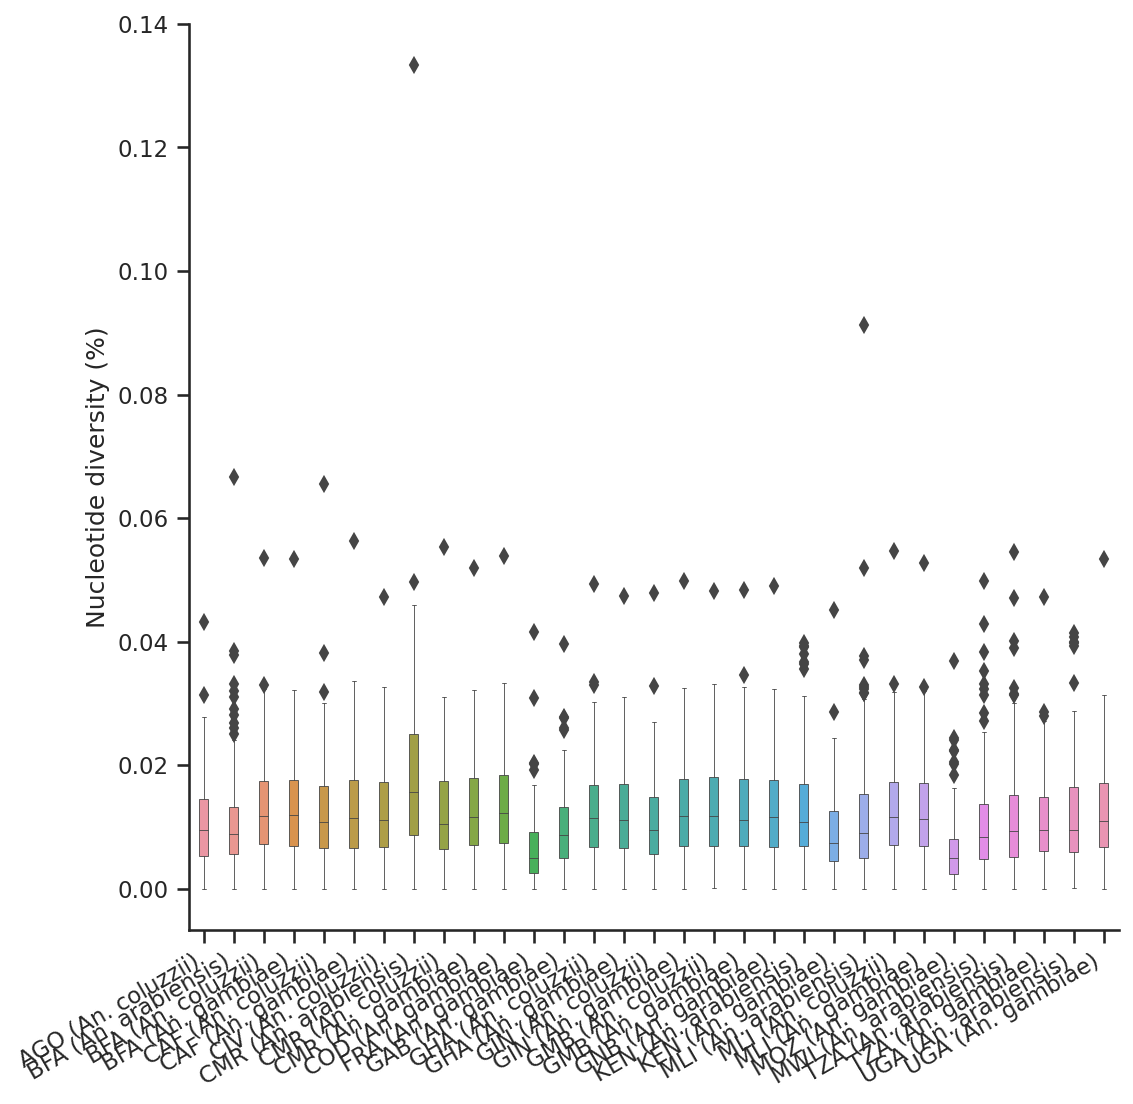

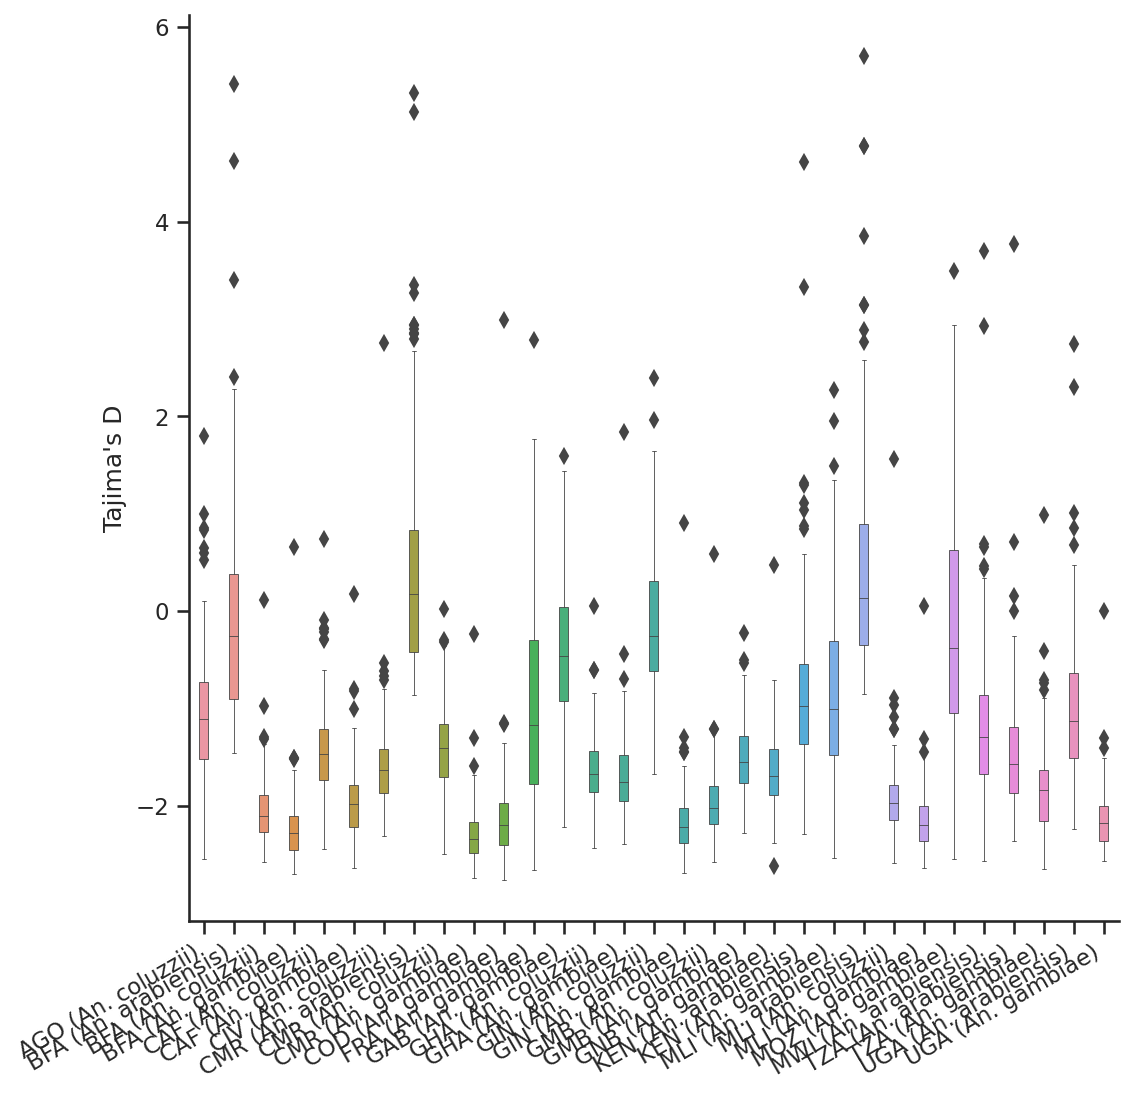

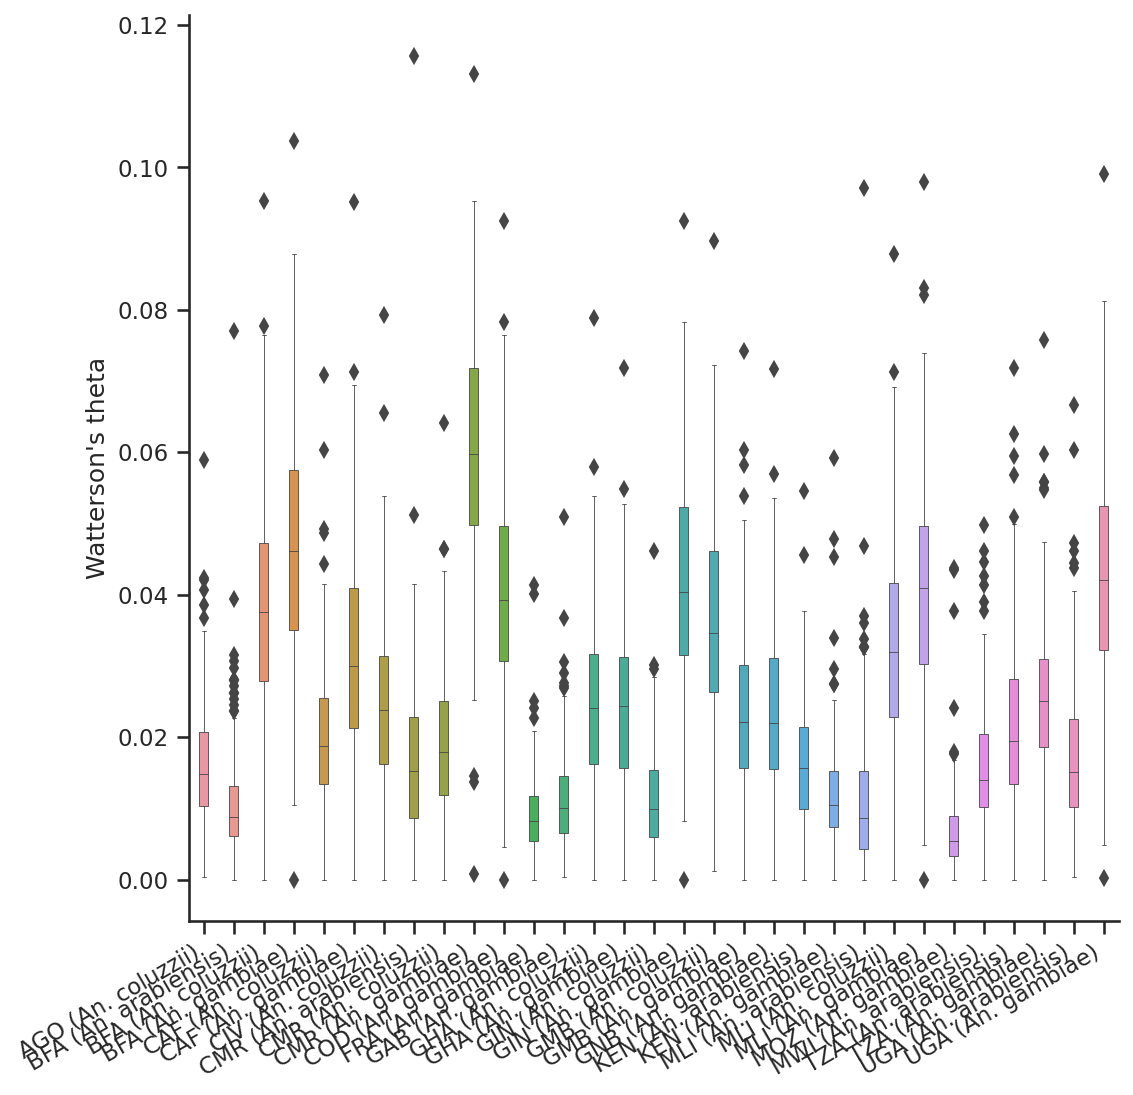

In [33]:
## Nucleotide diversity boxplot
sns.set_theme(style="ticks", color_codes=True)
fig, div_plot = plt.subplots(figsize = (8,8))
div_plot = sns.boxplot(x='pops', y='pi', data=Div_tab, width=0.3, linewidth=0.4)
div_plot.set(xlabel = '', ylabel = 'Nucleotide diversity (%)')
#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
plt.setp(div_plot.get_xticklabels(), rotation=30,  ha = 'right')
fig.savefig('Graph/plot_nuc_div', dpi=300, bbox_inches='tight')

## Tajima'D boxplot
sns.set_theme(style="ticks", color_codes=True)
fig, div_plot = plt.subplots(figsize = (8,8))
div_plot = sns.boxplot(x='pops', y='tajimaD', data=Div_tab, width=0.3, linewidth=0.4)
div_plot.set(xlabel = '', ylabel = "Tajima's D")
#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
plt.setp(div_plot.get_xticklabels(), rotation=30,  ha = 'right')
fig.savefig("Graph/plot_tadjima_D", dpi=300, bbox_inches='tight')


## Watterson's theta boxplot
sns.set_theme(style="ticks", color_codes=True)
fig, div_plot = plt.subplots(figsize = (8,8))
div_plot = sns.boxplot(x='pops', y='watt_theta', data=Div_tab, width=0.3, linewidth=0.4)
div_plot.set(xlabel = '', ylabel = "Watterson's theta")
#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
plt.setp(div_plot.get_xticklabels(), rotation=30,  ha = 'right')
fig.savefig("Graph/watt_theta", dpi=300, bbox_inches='tight')

In [34]:
def plot_windowed_variant_density(pos, window_size, title=None, ax=None, fig_name = None):
    
    # setup windows 
    bins = np.arange(pos.min(), pos.max(), window_size)
    
    # use window midpoints as x coordinate
    x = (bins[1:] + bins[:-1])/2
    
    # compute variant density in each window
    h, _ = np.histogram(pos, bins=bins)
    y = h / window_size
    
    # plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 3))
        sns.despine(ax=ax, offset=5)
    ax.plot(x, y, color = 'k',linestyle='-', linewidth=0.5)
    ax.set_xlabel('Chromosome X position (bp)')
    ax.set_ylabel('Variant density (bp$^{-1}$)')
    if title:
        ax.set_title(title)
    
    #tidy plot 
    ax.set_xlim(*(pos[0], pos[-1]))
    #ax.set_ylim(*ylim)
    ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])
    
    #save fig
    if fig_name:
        fig.savefig(f'Graph/{fig_name}', dpi=300, bbox_inches='tight')


/tmp/ipykernel_4080/3656990458.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])


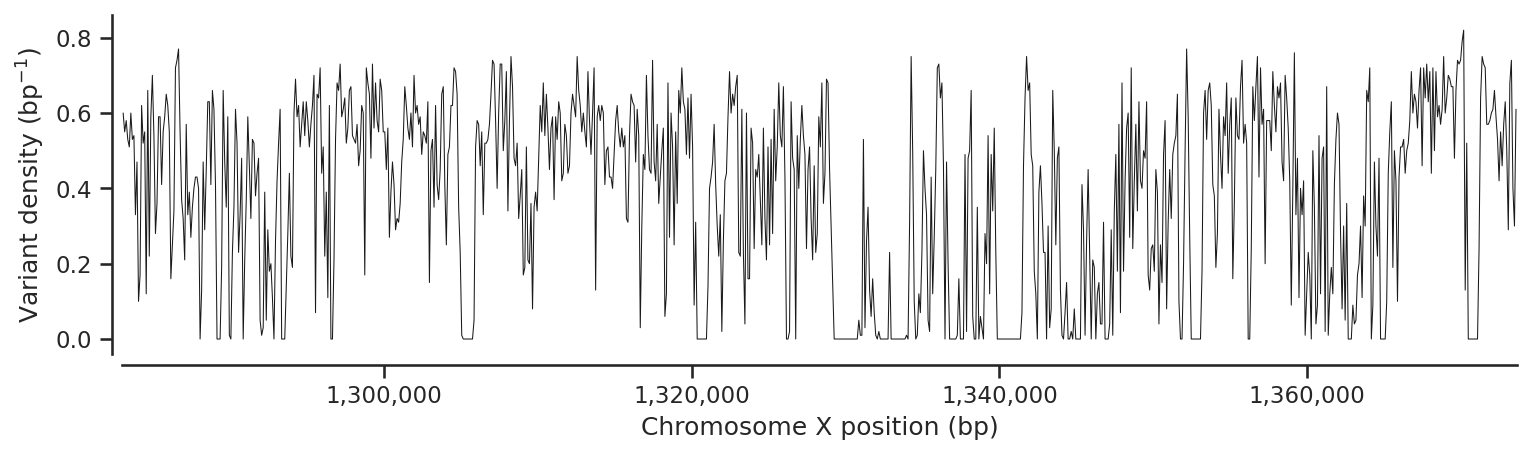

In [35]:
plot_windowed_variant_density(pos = pos, window_size=100, fig_name='var_density')

In [36]:
# Locate fru genomic region
loc_FRU = ('X', 1282900, 1373700)
loc_RC = ('X', 1283016, 1325015)
loc_RB = ('X', 1300109, 1325015)
loc_RA = ('X', 1308485, 1325015)
loc_RD = ('X', 1300109, 1373662)
loc_RE = ('X', 1308485, 1373662)
loc_FE = ('X', 1371770, 1373700) # sex specific region on the chromosome
loc_male = ('X', 1373540, 1373662)
loc_BTB = ('X', 1323400, 1325100)

#Import gene data set 
Fru_seq = pd.read_csv('Fru_genset.csv')
#Fru_seq

In [37]:
def plot_transcripts(geneset, height=.5, label_transcripts=True, label_exons=False, label_exon_size=False,
                     label_codons=False, highlight_exons=None, label_cdss=False, highlight_color='red', ax=None,
                     title=None, xlim=None, exon_label='{}', spec_pos=None, region_name=None, btb=None, 
                     include_transcripts=None):
    """Plot all transcripts for one or all genes overlapping a given region."""

    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 1))
    sns.despine(ax=ax, left=True, bottom=True)
        
    if title:
        ax.set_title(title, va='bottom')
    # find genes overlapping the given region 
    genes = geneset.query("(type == 'gene')").sort_values('start')

    # iterate over genes
    for _, gene in genes.iterrows():

        # find child transcripts
        transcripts = geneset.query("(type == 'DNA') and (Parent == %r)" % gene.gene_id).sort_values('gene_id')

        # iterate over transcripts
        for i, (_, transcript) in enumerate(transcripts.iterrows()):
            if include_transcripts is not None and transcript.gene_id not in include_transcripts:
                continue
            
            # coordinates for plotting the transcript
            if transcript.strand == '+':
                y = i
            else:
                y = -i - 1

            # annotate with transcript ID
            
            if xlim is not None:
                start, stop = xlim
                text_y = y + height + (height / 10)
                if label_transcripts == 'right':
                    text_x = min(stop, transcript.end)
                    ha = 'right'
                else:
                    text_x = max(start, transcript.start)
                    ha = 'left'
                if label_transcripts:
                    if transcript.strand == '+':
                        gene_id = str(transcript.gene_id).split('-')[0]
                        text = '%s >' % gene_id
                    else:
                        gene_id = str(transcript.gene_id).split('-')[0]
                        text = '< %s' % gene_id
                    ax.text(text_x, text_y, text, ha=ha, va='bottom', size=6)
            
            # find child exons
            exons = geneset.query("type == 'exon' and Parent == %r" % transcript.gene_id).sort_values('start')
            
            # iterate over exons to plot introns
            last_exon = None
            for i, (_, exon) in enumerate(exons.iterrows()):
                x = exon.start
                width = exon.end - x

                # plot intron
                if last_exon is not None:
                    ax.plot([last_exon.end, (last_exon.end + exon.start) / 2, exon.start], [y + height / 2, y + height / 1.5, y + height / 2], 'gray')
                last_exon = exon
                
                # exon number
                n = i + 1 if exon.strand == '+' else len(exons) - i

            # find child CDSs
            cdss = geneset.query("type == 'CDS' and Parent == %r" % transcript.gene_id)
            if transcript.strand == '+':
                cdss = cdss.sort_values('start', ascending=True)
            else:
                cdss = cdss.sort_values('end', ascending=False)
                
            # keep track of CDS position
            cds_pos = 0
            
            # plot CDSs
            for _, cds in cdss.iterrows():
                x = cds.start
                width = cds.end - x
                
                # plot CDS
                patch = plt.Rectangle((x, y), width, height, color='darkgray')
                ax.add_patch(patch)
                
                # accumulate CDS positions
                cds_pos += width + 1  

            # find child UTRs
            utrs = geneset.query("(type == 'three_prime_UTR' or type == 'five_prime_UTR') and Parent == %r" % transcript.gene_id).sort_values('start')
            for _, utr in utrs.iterrows():
                x = utr.start
                width = utr.end - x
                utr_height = height#* .8
                utr_y = y + (height - utr_height) / 2
                patch = plt.Rectangle((x, utr_y), width, utr_height, color='darkred')
                ax.add_patch(patch)

            # plot exons
            if transcript.strand == '+':
                exons = exons.sort_values('start', ascending=True)
            else:
                exons = exons.sort_values('end', ascending=False)
            for i, (_, exon) in enumerate(exons.iterrows()):
                x = exon.start
                width = exon.end - x
                exon_height = height#* .8
                exon_y = y + (height - exon_height) / 2
                patch = plt.Rectangle((x, exon_y), width, exon_height, facecolor='none', edgecolor='k', linewidth=0.01)
                ax.add_patch(patch)

                # label exons
                if label_exons == transcript.gene_id and xlim is not None:
#                     text_y = y - height/10
                    text_y = y + height/2
                    start, stop = xlim
                    if exon.end > start and exon.start < stop:
                        if exon.start < start:
                            text_x = (start + exon.end) / 2
                        elif exon.end > stop:
                            text_x = (exon.start + stop) / 2
                        else:
                            text_x = (exon.start + exon.end) / 2
                        s = exon_label.format(i + 1)
                        ax.text(text_x, text_y, s, ha='center', va='center', color='k', zorder=20)
    
    #plot specific region
    if spec_pos and btb:
        ax.add_patch(Rectangle((spec_pos[0], -1), spec_pos[1]-spec_pos[0], exon_height, edgecolor='darkgoldenrod', 
                               fill=False, lw=1, label=f'{region_name}'))
        ax.add_patch(Rectangle((btb[0], -1), btb[1]-btb[0], exon_height, edgecolor='magenta',
                               fill=False, lw=1, label='BTB region'))
            
    ax.set_yticks([])
    if xlim:
        ax.set_xlim(*xlim)
        ax.set_xticks([])
        ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks()])
        ax.autoscale(axis='y', tight=False)

#plot_transcripts1(Fru_seq, spec_pos=loc_male[1:], btb=loc_BTB[1:])

In [38]:
def var_density(data, xlim, window_size=100, window_step=None, pos = pos, 
                figsize=(9, 3), exon_label='{}', stop=None, fig_name = None):
    gs = plt.GridSpec(nrows=2, ncols=1, height_ratios=(0.08, 0.8))
    
    fig = plt.figure(figsize=figsize)
    
    # plot the gene model
    ax = fig.add_subplot(gs[0])
    plot_transcripts(data, ax=ax, xlim=xlim[1:])
    ax.set_xlim(*xlim[1:])
        
    # plot variant density
    position = pos.locate_range(xlim[1], xlim[2])
    ax = fig.add_subplot(gs[1])
    sns.despine(ax=ax, offset=5)
    plot_windowed_variant_density(pos, window_size=window_size, ax = ax) 
    ax.set_xlim(*(xlim[1], xlim[2]))
    fig.tight_layout()
    if fig_name:
        fig.savefig(f'Graph/{fig_name}.png', dpi=300, bbox_inches='tight')

#var_density(data=Fru_seq, xlim=loc_FRU, pos = pos, window_size=100)

/tmp/ipykernel_4080/3656990458.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])


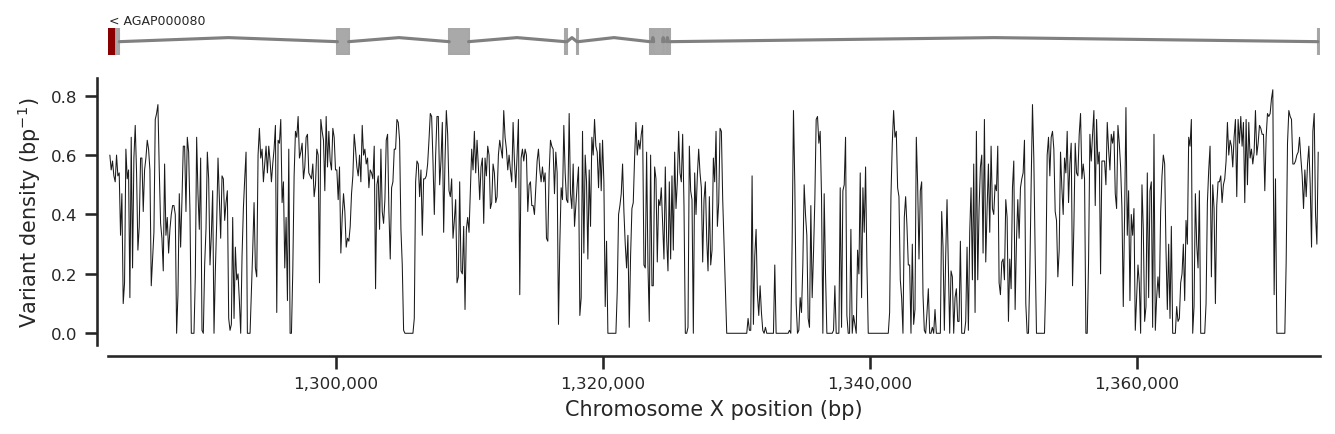

In [39]:
base_font_size = 10
rcParams['font.size'] = base_font_size
rcParams['axes.titlesize'] = base_font_size
rcParams['axes.labelsize'] = base_font_size
rcParams['xtick.labelsize'] = 8
rcParams['ytick.labelsize'] = 8
var_density(data=Fru_seq, xlim=loc_FRU, pos = pos, window_size=100, fig_name='Variant_density')

/tmp/ipykernel_4080/3673780822.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])


[Text(1280000.0, 0, '1,280,000'),
 Text(1300000.0, 0, '1,300,000'),
 Text(1320000.0, 0, '1,320,000'),
 Text(1340000.0, 0, '1,340,000'),
 Text(1360000.0, 0, '1,360,000'),
 Text(1380000.0, 0, '1,380,000')]

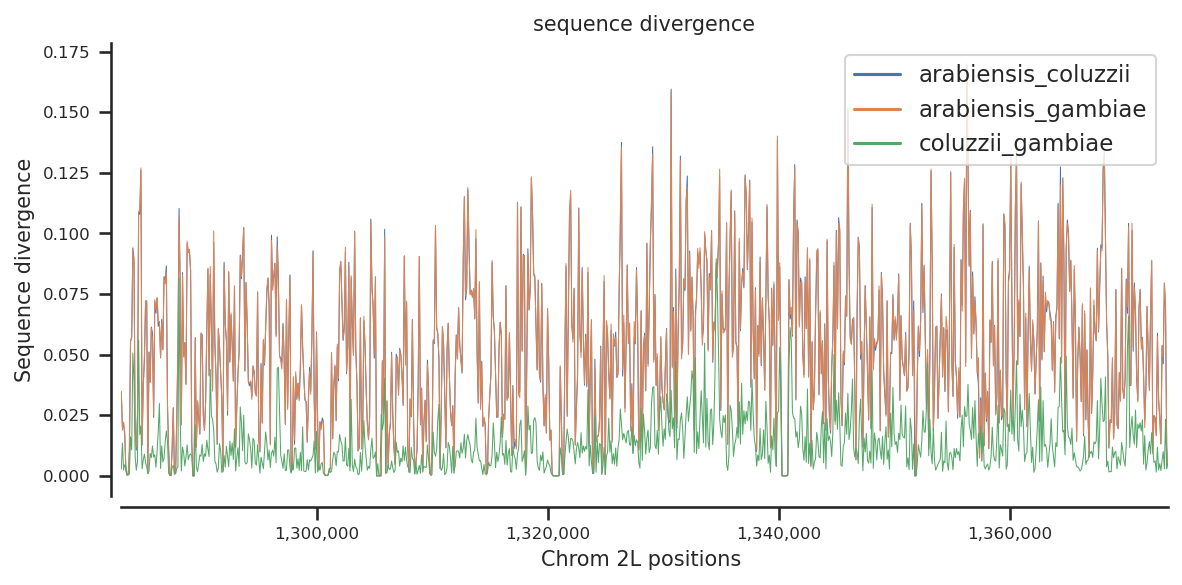

In [40]:
fig_data = df_divergence.melt('wind_pos', var_name='Crossed-Pop', value_name='values')
xlim1 = list(df_divergence.wind_pos)
# Plot sequence divergence per population 

fig, ax = plt.subplots(figsize=(9, 4))
sns.despine(ax=ax, offset=5)
ax = sns.lineplot(x = 'wind_pos', y = 'values', hue='Crossed-Pop', data=fig_data,   linewidth=.5)
ax.set(title = 'sequence divergence', xlabel = 'Chrom 2L positions ', ylabel = 'Sequence divergence')
ax.legend(loc="upper right")
xlim=[xlim1[0], xlim1[-1]]
ax.set_xlim(*xlim)
ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])